# Chapter7. RNN을 사용한 문장 생성

## 1. 언어 모델을 사용한 문장 생성

### 1.1 RNN을 사용한 문장 생성의 순서

- 언어모델은 한 단어를 입력하면 총 단어(중복 X)에서 다음에 출현하는 단어의 확률분포를 출력.
- 해당 결과를 기초로 다음 단어를 새로 생성하는 방법
- 예측값을 새로운 input으로 넣어주는 작업을 계속하며 문장을 생성, 특정한 끝맺음 단어를 만나면 해당 작업을 중단
    1. 확률이 가장 높은 단어를 선택(**결정적(deterministic) 방법**, 항상 일정한 결과)
    2. 확률적으로 단어를 선택(**확률적(probabilistic) 방법**, 매번 같은 결과는 X)

- 새로 생성되는 문장은 훈련 데이터에서 사용된 단어의 정렬 패턴을 학습하여 새로 생성하는 문장. 올바르게 학습 되었다면, 그 모델이 새로 생성하는 문장은 자연스럽고 의미가 통하는 문장일 것이라 기대할 수 있음

### 1.2 문장 생성 구현
- 기존의 Rnnlm 클래스를 계승하여 새로운 클래스를 만드는 매커니즘
- Rnnlm은 time과 관련없는 input 가능.
    - RnnlmTrainer 의 경우 batch size로 진행되기 때문에 같은 time size로 맞춰짐
- epoch 시에 self.h를 reset하지 않으면 앞의 input들의 영향을 받은 채로 forward가 진행됨

In [27]:
import sys
import os
sys.path.append(os.path.join("..","function"))
#sys.path.append(os.path.join("..","master"))
import numpy as np
from base_function import *
from Rnnlm import *
from better_rnnlm import BetterRnnlm

class RnnlmGen(Rnnlm):
    def generate(self, start_id, skip_ids = None, sample_size = 100):
        """
        start_id    : 최초로 주는 단어의 ID
        sample_size : 샘플링하는 단어의 수
        skip_idx    : 샘플링에서 제외되는 단어 ID의 리스트
        """
        word_ids = [start_id] # 첫번째로 오는 것은 예측되는 것이 아니기 때문에 넣어놓음
        
        x = start_id
        while len(word_ids) < sample_size:
            # self.h를 reset하지 않기 때문에 이전 단어들에 이어서 예측이 됨
            x = np.array(x).reshape(1,1)
            score = self.predict(x)       
            p = softmax(score.flatten()) # score 정규화
            
            # 0~len(p)-1 까지의 숫자 중 p확률에 따라 하나를 샘플링
            sampled = np.random.choice(len(p), size = 1, p=p)
            # 샘플링에서 제외되는 단어가 없거나 샘플링에서 제외되는 단어가 아니면 배열에 추가
            if (skip_ids is None) or (sampled not in skip_ids):
                x = sampled
                word_ids.append(int(x))
                
        return word_ids # 단어 배열을 출력
    

- 훈련되지 않은 model로 문장 생성

In [11]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id) # 총 단어 개수
corpus_size = len(corpus)    # 총 단어 길이

model = RnnlmGen()

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N","<unk>","$"] # 희소한 숫자, 희소한 단어
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>",".\n")
print(txt)

you & regulators turned to dividends payable represent ind. amex ignorance helicopter convert cable-tv walters produced approximately warsaw saving transplants stage root crash practical reruns music energetic bryant mile coupons working photographs asset-backed moore brown-forman commonwealth book pennsylvania replacement banker indicated mild u.n. termination homeowners friends chose staying defaulted davis douglas due picop named lexington ramada colon least highways cross-border boiler cie inappropriate beer producer play approval sits notified faculty bondholders cholesterol double-a abc gop high-definition libya ken compromise hard-disk reporters president resist last reitman drilling ballooning necessary alvin stressed supreme hubbard thus occurred nrm azoff prominent narrowly humanitarian refusal


- 훈련된 model로 문장 생성

In [19]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id) # 총 단어 개수
corpus_size = len(corpus)    # 총 단어 길이

model = RnnlmGen()
model.load_params("../master/ch06/Rnnlm.pkl") # 가중치 매개변수를 읽어들임

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N","<unk>","$"] # 희소한 숫자, 희소한 단어
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>",".\n")
print(txt)

you sweep cooperation statutes stamford snapped duff capability mood kentucky outnumbered convictions kenneth unfortunate plane revolutionary transplants clients spoken hong organized royalties renew enviropact chile ron dole course turns statutes chung slight fame county denies tunnel straight charity shows bureaus hang carrying fla softness stolen trotter peasants dd colgate-palmolive espn ga. coated grants dd hold barring politician minerals ailing discovered scramble novelist prevention glory payment judges commodity ranged bartlett scientist heard foot capitalists apartheid worthy shaping achieve structures cocoa sporting fm first-time professors properties concerns overruns publishing military launching again hasbro risks fight capable issues mclennan heightened disappointing covers destroyed


- 더 나은 훈련된 모델로 문장 생성

In [21]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id) # 총 단어 개수
corpus_size = len(corpus)    # 총 단어 길이

model = RnnlmGen()
model.load_params("./BetterRnnlm.pkl") # 가중치 매개변수를 읽어들임

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_word = "you"
start_id = word_to_id[start_word]
skip_words = ["N","<unk>","$"] # 희소한 숫자, 희소한 단어
skip_ids = [word_to_id[w] for w in skip_words]

# 문장 생성
word_ids = model.generate(start_id, skip_ids)
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>",".\n")
print(txt)

you penn pound lenses district consisting capitol dependent kate congressman tw valued loosen arrive rockwell debenture insurers c.d.s miles industry mature unpaid coca-cola wiped hostile 1950s heightened turkey searches analysis swung jumped registered jury life-insurance albert massachusetts singapore snapped agreement universe informed newly non-food enabling snack-food dependent humana solve u.s.-soviet uniform beer pound tells computer-driven mcdonald connolly establishing trains oils tell concentrate stern tuesday investment depository staffs travelers destroyed gramm-rudman intel neatly plunged dinner visa should templeton wilmington track tests kellogg negligible headed sooner generic soldiers embarrassment hot enjoying somewhat motive achieve extend cents backlash example adjuster ray get access


In [43]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
from rnnlm_gen import RnnlmGen
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data("train")
vocab_size = len(word_to_id) # 총 단어 개수
corpus_size = len(corpus)    # 총 단어 길이

model = RnnlmGen()
model.load_params("./BetterRnnlm.pkl") # 가중치 매개변수를 읽어들임

# 시작(start) 문자와 건너뜀(skip) 문자 설정
start_words = "the meaning of life is"
start_ids = [word_to_id[w] for w in start_words.split(" ")]
skip_words = ["N","<unk>","$"] # 희소한 숫자, 희소한 단어
skip_ids = [word_to_id[w] for w in skip_words]

for x in start_ids[:-1]:
    # 해당 단어들의 영향을 주기 위해서 predict를 진행
    model.predict(np.array(x).reshape(1,1)) 

# 문장 생성
# 'is'가 첫 단어로 사용되어서 list에 담기기 때문에 start_ids[:-1]로 해주어야 함
word_ids = model.generate(start_ids[-1], skip_ids)
word_ids = start_ids[:-1]+word_ids
txt = " ".join([id_to_word[i] for i in word_ids])
txt = txt.replace(" <eos>",".\n")
print(txt)

the meaning of life is volume play competitive asia patch fined convex harvest published comair 1950s haunts cheered jacobson near policies concentrate brazil mandatory firmed he kohlberg frustrated grower departures mgm\/ua month mart airline war sluggish unilever incredible 'd rolling sidelines colgate ethiopia beleaguered elegant year-earlier river beef careful kentucky lama delegates farm prestige inches clothes scandals options escrow statements notorious describes ratings suggestions maker probability purposes through struggle pushing measures form appears superfund no. numbers violate married monsanto conferences high-priced seized big-time wade toxin revisions rein earned mail-order winner based strengthened phone fletcher airport decker examined quote nancy enserch traub violated exploit columns


## 2. Seq2Seq(Sequence to Sequence)
- **시계열 데이터(ex 언어 데이터, 음성 데이터, 동영상 데이터)를 '또 다른' 시계열 데이터로 변환**하는 모델의 방법
- 입력과 출력이 시계열 데이터인 문제를 다루는 방법

### 2.1 seq2seq의 원리

- seq2seq는 Encoder-Decoder model이라고도 불림
- 2개의 모듈이 존재.
    - Encoder : 입력 데이터를 인코딩(부호화)
    - Decoder : 인코딩된 데이터를 디코딩(복호화)
        - 인코딩 : 정보를 어떤 규칙에 따라 변환하는 것
        - 디코딩 : 인코딩된 정보를 원래의 정보로 되돌리는 것

ex) 나는 고양이로소이다 -> Encoding -> Decoding -> I am a cat

#### Encoder
- 입력 : 시계열 데이터(출발어)
- 출력 : LSTM 계층의 마지막 은닉상태(h)
    - 마지막 은닉 상태 h에 입력 문장을 번역하는 데 필요한 정보가 인코딩
    - 일반적으로 memory cell은 출력하지 않음. memory cell은 자기 자신 내에서만 완결되고, 다른 계층으로는 출력하지 않는다는 것을 전제하고 만들어졌기 때문
- 은닉상태 h는 고정길이 벡터이기 때문에 **인코딩하다라함은 임의 길이 문장을 고정 길이 벡터로 변환하는 작업**

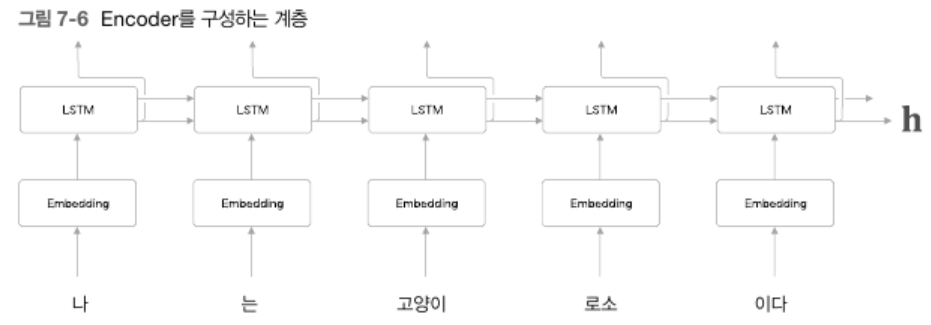

#### Decoder
- 입력 : 시계열 데이터(도착어)
- LSTM layer input : encoder의 벡터 h
- 출력 : 시계열 데이터(도착어)
    - '< eos >' : 문장 생성의 시작/종료를 알리는 구분자로 사용한 기호. 이 외의 다른 기호도 사용 가능
- LSTM 계층이 벡터 h를 입력받는다는 점을 제외하고 앞 절의 신경망와 완전히 같은 구성

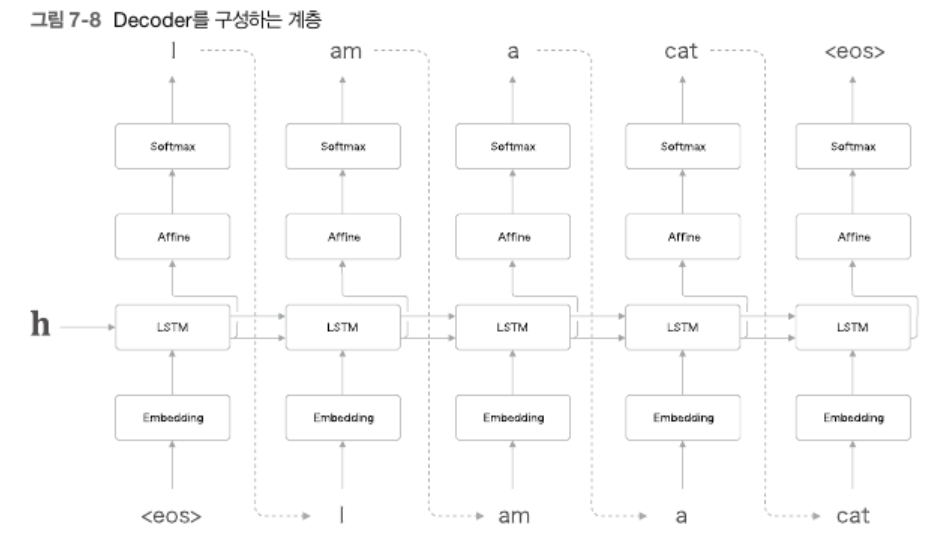

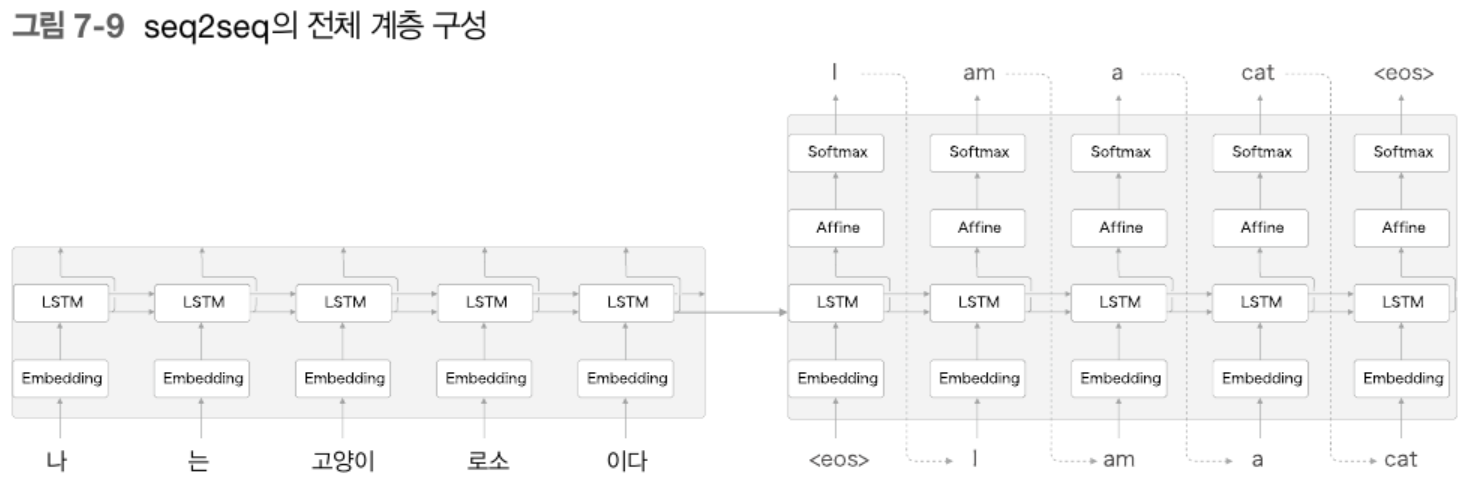

### 2.2 시계열 데이터 변환용 장난감 문제
- '52+52' -> '104' 를 출력하는 장난감 문제

- '단어' 단위 분할 : '단어'를 기준으로 분할
- '문자' 단위 분할 : '문자'를 기준으로 분할

### 2.3 가변 길이 시계열 데이터
- '미니배치 처리'를 하려면 시계열 길이가 모두 같아야 함. 따라서 가변 길이 시계열 데이터의 경우 형상을 똑같이 해줘야 함
    - 출발어, 도착어 각각 형상을 같게 만들어 주어야 함

- **데이터 형상을 같게 하기 위한 방법**
    - 패딩(padding) : 원래의 데이터에 의미 없는(공백/0) 데이터를 채워 모든 데이터의 길이를 균일하게 맞추는 방법
        - 정확성을 높이려면 seq2seq에 패딩 전용 처리가 추가되어야 함

### 2.4 덧셈 데이터셋

In [55]:
import sys
import os
sys.path.append(os.path.join("..","master"))
from dataset import sequence
import numpy as np

# load_data -> 데이터를 한 줄 씩 읽고, 각 문자를 ID로 변경한 train, test set을 생성
(x_train, t_train), (x_test, t_test) = \
        sequence.load_data("addition.txt", seed = 1984)
char_to_id, id_to_char = sequence.get_vocab()

print(x_train.shape, t_train.shape)
print(x_test.shape, t_test.shape)

print(x_train[0])
print(t_train[0])

print(''.join([id_to_char[c] for c in x_train[0]]))
print(''.join([id_to_char[c] for c in t_train[0]]))

(45000, 7) (45000, 5)
(5000, 7) (5000, 5)
[ 3  0  2  0  0 11  5]
[ 6  0 11  7  5]
71+118 
_189 


## 3. seq2seq 구현

### 3.1 Encoder class

In [56]:
import sys
import os
sys.path.append(os.path.join("..","master"))
sys.path.append(os.path.join("..","function"))
from dataset import sequence
from common.base_model import *
from time_layers import *
import numpy as np

class Encoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D)/100).astype("f")
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype("f")
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype("f")
        lstm_b = np.zeros(4*H).astype("f")
        
        self.embed = TimeEmbedding(embed_W)
        # '긴 시계열 데이터'가 하나뿐인 문제를 다뤘을 때는 stateful = True
        # '짧은 시계열 데이터'가 여러개인 문제를 다룰 때는 stateful = False
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=False)
        
        self.params = self.embed.params + self.lstm.params
        self.grads = self.embed.grads + self.lstm.grads
        self.hs = None # 다음 계층으로 보내기 위한 hs
        
    def forward(self, xs):
        xs = self.embed.forward(xs)
        hs = self.lstm.forward(xs)
        self.hs = hs
        return hs[:, -1, :] # LSTM layer의 마지막 출력만 사용
    
    def backward(self, dh):
        # 끊기기 때문에 마지막 layer 빼고는 0의 gradient가 옴
        dhs = np.zeros_like(self.hs) 
        dhs[:, -1, :] = dh
        
        dout = self.lstm.backward(dhs)
        dout = self.embed.backward(dout)
        return dout

### 3.2 Decoder class
- 학습 시에는 input이 한번에 주어지지만, 생성(예측)시에는 최초 시작 문자 하나만 input으로 넣음. 그 후 그 출력으로부터 문자를 하나씩 샘플링 하여 그 샘플링한 문자를 다음 입력으로 사용하는 과정을 반복
- 문제의 성격에 맞게 '결정적'선택 방법을 사용
    - 예측 시 softmax 함수 적용 없이 score만 계산하면 됨.

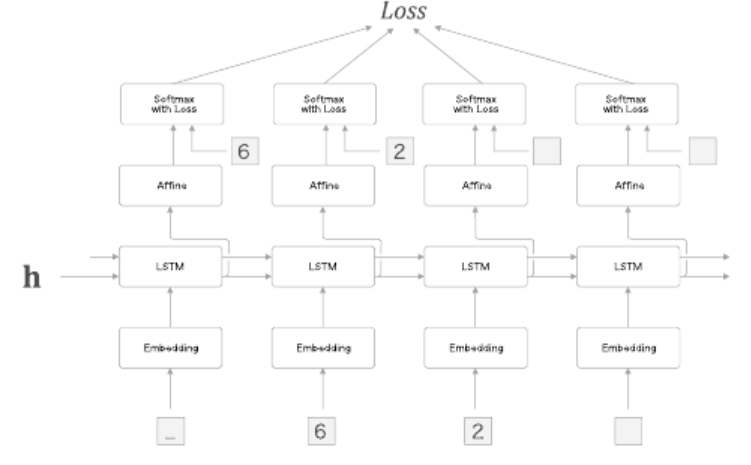

In [ ]:
class Decoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V,D)/100).astype("f")
        lstm_Wx = (rn(D, 4*H)/np.sqrt(D)).astype("f")
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype("f")
        lstm_b = np.zeros(4*H).astype("f")
        affine_W = (rn(H,V)/np.sqrt(H)).astype("f")
        affine_b = np.zeros(V).astype("f")
        
        self.embed = TimeEmbedding(embed_W)
        
        # encoder의 상태를 갖도록 해야하기 때문에 stateful = True
        # 매 배치마다 encoder에서 출력된 h를 hidden state로 재설정해주기 때문에
        # 짧은 여러 시계열 데이터라도 적절하게 hidden state가 반영됨
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, h): # 훈련시 사용
        self.lstm.set_state(h) # encoder에서 출력된 hidden state를 설정
        
        out = self.embed.forward(xs)
        out = self.lstm.forward(out)
        score = self.affine.forward(out)
        return score
    
    def backward(self, dscore):
        dout = self.affine.backward(dscore)
        dout = self.lstm.backward(dout)
        dout = self.embed.backward(ddout)
        dh = self.lstm.dh
        return dh # encoder에 적용하기 위해
    
    def generate(self, h, start_id, sample_size): # 생성시 사용
        sampled = []
        sample_id = start_id
        self.lstm.set_state(h)
        
        for _ in range(sample_size):
            x = np.array(sample_id).reshape(1,1) # 배치처리
            out = self.embed.forward(x)
            out = self.lstm.forward(out)
            score = self.affine.forward(out)
            
            sample_id = np.argmax(score.flatten())
            sampled.append(int(sample_id))
            
        return sampled

### 3.3 Seq2seq class
- Encoder class와 Decoder class를 연결하고, Time Softmax with Loss layer을 이용해 손실을 계산

In [ ]:
class Seq2seq(BaseModel):
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = Decoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads
        
    def forward(self, xs, ts): # 훈련시 사용
        # 도착어가 decoder의 input과 output이 됨
        decoder_xs, decoder_ts = ts[:,:-1], ts[:,1:]
        h = self.encoder.forward(xs)
        # 출발어가 encoder의 input, h가 output
        score = self.decoder.forward(decoder_xs, h)
        loss = self.softmax.forward(score,decoder_ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.softmax.backward(dout)
        dh = self.decoder.backward(dout)
        dout = self.encoder.backward(dh)
        return dout
    
    def generate(self, xs, start_id, sample_size): # 생성시 사용
        h = self.encoder.forward(xs)
        sampled = self.decoder.generate(h, start_id, sample_size)
        return sampled

### 3.4 seq2seq 평가
1. 학습 데이터에서 mini-batch 선택
2. 미니배치로부터 gradient 계산
3. gradient를 사용하여 parameter update
4. 정답률을 평가척도로 사용

In [1]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq
from matplotlib import font_manager, rc
import matplotlib as mpl
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
mpl.rcParams["axes.unicode_minus"]=False


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / optimizer / trainer 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1,
               batch_size = batch_size, max_grad = max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 각 data를 불러옴
        verbose = i<10  # 앞 10개 시계열 데이터의 결과만 출력
        # question은 출발어 correct는 도착어, verbose는 eval 결과를 출력할지 여부
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
    
    # 정답률을 평가 척도로 사용
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("검증 정확도 %.3f%%" %(acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.53
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.92
| 에폭 1 |  반복 101 / 351 | 시간 4[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 5[s] | 손실 1.85
| 에폭 1 |  반복 141 / 351 | 시간 6[s] | 손실 1.83
| 에폭 1 |  반복 161 / 351 | 시간 7[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 8[s] | 손실 1.77
| 에폭 1 |  반복 201 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 10[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 281 / 351 | 시간 13[s] | 손실 1.75
| 에폭 1 |  반복 301 / 351 | 시간 14[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 15[s] | 손실 1.75
| 에폭 1 |  반복 341 / 351 | 시간 16[s] | 손실 1.74
Q 77+85  
T 162 
X 100 
---
Q 975+164
T 1139
X 1000
---
Q 582+84 
T 666 
X 1000
---
Q 8+155  
T 163 
X 100 
---
Q 367+55 
T 422 
X 1000
---
Q 600+257
T 857 
X 1000
---
Q 761+292
T 1053
X 1000
---
Q 830+597
T 1427
X 1000
---
Q

| 에폭 8 |  반복 341 / 351 | 시간 18[s] | 손실 1.05
Q 77+85  
T 162 
X 166 
---
Q 975+164
T 1139
X 1160
---
Q 582+84 
T 666 
X 668 
---
Q 8+155  
T 163 
X 173 
---
Q 367+55 
T 422 
X 438 
---
Q 600+257
T 857 
X 873 
---
Q 761+292
T 1053
X 1073
---
Q 830+597
T 1427
X 1449
---
Q 26+838 
T 864 
X 868 
---
Q 143+93 
T 236 
X 253 
---
검증 정확도 2.880%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 1.05
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 1.02
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 1.00
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.99
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 0.99
| 에폭 9 |  반복 101 / 351 | 시간 5[s] | 손실 0.99
| 에폭 9 |  반복 121 / 351 | 시간 6[s] | 손실 0.99
| 에폭 9 |  반복 141 / 351 | 시간 7[s] | 손실 0.99
| 에폭 9 |  반복 161 / 351 | 시간 8[s] | 손실 1.01
| 에폭 9 |  반복 181 / 351 | 시간 10[s] | 손실 0.99
| 에폭 9 |  반복 201 / 351 | 시간 11[s] | 손실 0.98
| 에폭 9 |  반복 221 / 351 | 시간 12[s] | 손실 0.98
| 에폭 9 |  반복 241 / 351 | 시간 13[s] | 손실 0.99
| 에폭 9 |  반복 261 / 351 | 시간 14[s] | 손실 0.99
| 에폭 9 |  반복 281 / 351 | 시간 15[s] | 손실 0.98
| 에폭 9 |  반복 301 

| 에폭 16 |  반복 141 / 351 | 시간 6[s] | 손실 0.87
| 에폭 16 |  반복 161 / 351 | 시간 7[s] | 손실 0.88
| 에폭 16 |  반복 181 / 351 | 시간 8[s] | 손실 0.87
| 에폭 16 |  반복 201 / 351 | 시간 9[s] | 손실 0.84
| 에폭 16 |  반복 221 / 351 | 시간 10[s] | 손실 0.85
| 에폭 16 |  반복 241 / 351 | 시간 11[s] | 손실 0.91
| 에폭 16 |  반복 261 / 351 | 시간 12[s] | 손실 0.88
| 에폭 16 |  반복 281 / 351 | 시간 13[s] | 손실 0.89
| 에폭 16 |  반복 301 / 351 | 시간 14[s] | 손실 0.86
| 에폭 16 |  반복 321 / 351 | 시간 15[s] | 손실 0.83
| 에폭 16 |  반복 341 / 351 | 시간 16[s] | 손실 0.85
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1129
---
Q 582+84 
T 666 
X 667 
---
Q 8+155  
T 163 
X 158 
---
Q 367+55 
T 422 
X 419 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1049
---
Q 830+597
T 1427
X 1418
---
Q 26+838 
T 864 
X 862 
---
Q 143+93 
T 236 
X 235 
---
검증 정확도 8.200%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.83
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.84
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0.86
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.88
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.88
|

검증 정확도 10.120%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.75
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.81
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.78
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.78
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.78
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.77
| 에폭 24 |  반복 121 / 351 | 시간 5[s] | 손실 0.78
| 에폭 24 |  반복 141 / 351 | 시간 6[s] | 손실 0.78
| 에폭 24 |  반복 161 / 351 | 시간 7[s] | 손실 0.81
| 에폭 24 |  반복 181 / 351 | 시간 8[s] | 손실 0.77
| 에폭 24 |  반복 201 / 351 | 시간 9[s] | 손실 0.77
| 에폭 24 |  반복 221 / 351 | 시간 10[s] | 손실 0.80
| 에폭 24 |  반복 241 / 351 | 시간 11[s] | 손실 0.77
| 에폭 24 |  반복 261 / 351 | 시간 12[s] | 손실 0.77
| 에폭 24 |  반복 281 / 351 | 시간 13[s] | 손실 0.79
| 에폭 24 |  반복 301 / 351 | 시간 14[s] | 손실 0.82
| 에폭 24 |  반복 321 / 351 | 시간 15[s] | 손실 0.76
| 에폭 24 |  반복 341 / 351 | 시간 16[s] | 손실 0.77
Q 77+85  
T 162 
X 161 
---
Q 975+164
T 1139
X 1127
---
Q 582+84 
T 666 
X 655 
---
Q 8+155  
T 163 
X 167 
---
Q 367+55 
T 422 
X 415 
---
Q 600+257
T 857 
X 856 
---
Q 761+292
T 1053
X 1059


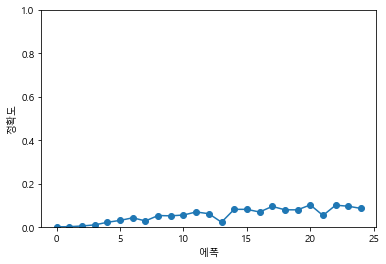

In [6]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker = "o")
plt.xlabel("에폭")
plt.ylabel("정확도")
plt.ylim(0,1.0)
plt.show()

## 4. seq2seq 개선

### 4.1 입력 데이터 반전(Reverse)
- 입력 데이터를 반전시키면, 학습 진행이 빨라져서 결과적으로 최종 정확도도 좋아지는 결과를 얻을 수 있음
    - 모든 경우에 그렇진 않지만 대부분의 경우 더 좋은 결과로 이어짐
- 직관적인 이유로는 기울기 전파가 원활해지기 때문('평균'적인 거리는 같지만)
    - ex) "나 는 고양이 이다" -> "I am a cat" 인 task가 있다고 한다면, "I"로부터 전해지는 기울기가 "나"까지 도달하기 까지 먼 거리만큼 영향을 받음. 하지만 "이다 고양이 는 나" -> "I am a cat"이라면 "I"로부터 전해지는 기울기가 "나"까지 도달하기 까지 거리가 가까워지므로 학습 효율이 좋아질 수 있음(*평균적인 거리는 같을지라도*)
    - 첫 예측 결과가 다음 시각의 input으로 들어가고 이 것이 반복되기 때문에 첫 예측결과가 중요
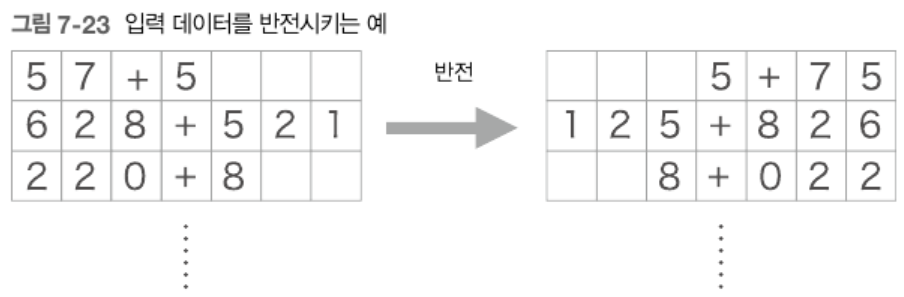

In [11]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from ch07.peeky_seq2seq import PeekySeq2seq
from matplotlib import font_manager, rc
import matplotlib as mpl
font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
mpl.rcParams["axes.unicode_minus"]=False


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # 데이터를 반전시켜줌
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / optimizer / trainer 생성
model = Seq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1,
               batch_size = batch_size, max_grad = max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 각 data를 불러옴
        verbose = i<10  # 앞 10개 시계열 데이터의 결과만 출력
        # question은 출발어 correct는 도착어, verbose는 eval 결과를 출력할지 여부
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
    
    # 정답률을 평가 척도로 사용
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("검증 정확도 %.3f%%" %(acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.56
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.52
| 에폭 1 |  반복 41 / 351 | 시간 1[s] | 손실 2.17
| 에폭 1 |  반복 61 / 351 | 시간 2[s] | 손실 1.96
| 에폭 1 |  반복 81 / 351 | 시간 3[s] | 손실 1.91
| 에폭 1 |  반복 101 / 351 | 시간 4[s] | 손실 1.87
| 에폭 1 |  반복 121 / 351 | 시간 5[s] | 손실 1.86
| 에폭 1 |  반복 141 / 351 | 시간 6[s] | 손실 1.84
| 에폭 1 |  반복 161 / 351 | 시간 7[s] | 손실 1.80
| 에폭 1 |  반복 181 / 351 | 시간 8[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 9[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 241 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 11[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 12[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 13[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 14[s] | 손실 1.74
| 에폭 1 |  반복 341 / 351 | 시간 15[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1000
---
Q  48+285
T 666 
X 1001
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1001
---
Q 752+006
T 857 
X 1000
---
Q 292+167
T 1053
X 1000
---
Q 795+038
T 1427
X 1000
---
Q

| 에폭 8 |  반복 341 / 351 | 시간 14[s] | 손실 0.57
Q   58+77
T 162 
X 163 
---
Q 461+579
T 1139
X 1134
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
X 162 
---
Q  55+763
T 422 
X 423 
---
Q 752+006
T 857 
X 759 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1431
---
Q  838+62
T 864 
X 866 
---
Q  39+341
T 236 
X 238 
---
검증 정확도 23.080%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.55
| 에폭 9 |  반복 21 / 351 | 시간 0[s] | 손실 0.56
| 에폭 9 |  반복 41 / 351 | 시간 1[s] | 손실 0.56
| 에폭 9 |  반복 61 / 351 | 시간 2[s] | 손실 0.55
| 에폭 9 |  반복 81 / 351 | 시간 3[s] | 손실 0.54
| 에폭 9 |  반복 101 / 351 | 시간 4[s] | 손실 0.55
| 에폭 9 |  반복 121 / 351 | 시간 5[s] | 손실 0.55
| 에폭 9 |  반복 141 / 351 | 시간 6[s] | 손실 0.54
| 에폭 9 |  반복 161 / 351 | 시간 6[s] | 손실 0.55
| 에폭 9 |  반복 181 / 351 | 시간 7[s] | 손실 0.53
| 에폭 9 |  반복 201 / 351 | 시간 8[s] | 손실 0.54
| 에폭 9 |  반복 221 / 351 | 시간 9[s] | 손실 0.54
| 에폭 9 |  반복 241 / 351 | 시간 10[s] | 손실 0.53
| 에폭 9 |  반복 261 / 351 | 시간 11[s] | 손실 0.53
| 에폭 9 |  반복 281 / 351 | 시간 11[s] | 손실 0.54
| 에폭 9 |  반복 301 / 

| 에폭 16 |  반복 141 / 351 | 시간 5[s] | 손실 0.36
| 에폭 16 |  반복 161 / 351 | 시간 6[s] | 손실 0.37
| 에폭 16 |  반복 181 / 351 | 시간 7[s] | 손실 0.36
| 에폭 16 |  반복 201 / 351 | 시간 8[s] | 손실 0.38
| 에폭 16 |  반복 221 / 351 | 시간 9[s] | 손실 0.38
| 에폭 16 |  반복 241 / 351 | 시간 9[s] | 손실 0.36
| 에폭 16 |  반복 261 / 351 | 시간 10[s] | 손실 0.35
| 에폭 16 |  반복 281 / 351 | 시간 11[s] | 손실 0.35
| 에폭 16 |  반복 301 / 351 | 시간 12[s] | 손실 0.35
| 에폭 16 |  반복 321 / 351 | 시간 13[s] | 손실 0.35
| 에폭 16 |  반복 341 / 351 | 시간 14[s] | 손실 0.37
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
X 1142
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
X 858 
---
Q 292+167
T 1053
X 1054
---
Q 795+038
T 1427
X 1430
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
X 237 
---
검증 정확도 42.700%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.34
| 에폭 17 |  반복 21 / 351 | 시간 0[s] | 손실 0.36
| 에폭 17 |  반복 41 / 351 | 시간 1[s] | 손실 0.36
| 에폭 17 |  반복 61 / 351 | 시간 2[s] | 손실 0.35
| 에폭 17 |  반복 81 / 351 | 시간 3[s] | 손실 0.36
| 

검증 정확도 45.160%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.31
| 에폭 24 |  반복 21 / 351 | 시간 0[s] | 손실 0.29
| 에폭 24 |  반복 41 / 351 | 시간 1[s] | 손실 0.28
| 에폭 24 |  반복 61 / 351 | 시간 2[s] | 손실 0.29
| 에폭 24 |  반복 81 / 351 | 시간 3[s] | 손실 0.30
| 에폭 24 |  반복 101 / 351 | 시간 4[s] | 손실 0.29
| 에폭 24 |  반복 121 / 351 | 시간 4[s] | 손실 0.29
| 에폭 24 |  반복 141 / 351 | 시간 5[s] | 손실 0.29
| 에폭 24 |  반복 161 / 351 | 시간 6[s] | 손실 0.28
| 에폭 24 |  반복 181 / 351 | 시간 7[s] | 손실 0.29
| 에폭 24 |  반복 201 / 351 | 시간 8[s] | 손실 0.28
| 에폭 24 |  반복 221 / 351 | 시간 8[s] | 손실 0.28
| 에폭 24 |  반복 241 / 351 | 시간 9[s] | 손실 0.29
| 에폭 24 |  반복 261 / 351 | 시간 10[s] | 손실 0.29
| 에폭 24 |  반복 281 / 351 | 시간 11[s] | 손실 0.29
| 에폭 24 |  반복 301 / 351 | 시간 12[s] | 손실 0.28
| 에폭 24 |  반복 321 / 351 | 시간 12[s] | 손실 0.27
| 에폭 24 |  반복 341 / 351 | 시간 13[s] | 손실 0.29
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
X 421 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
X 1054
--

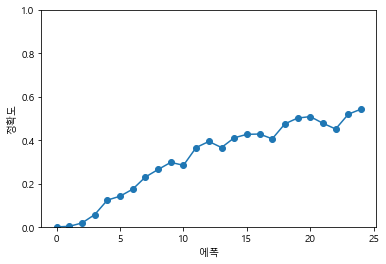

In [12]:
# 그래프 그리기
x = np.arange(len(acc_list))
plt.plot(x, acc_list, marker = "o")
plt.xlabel("에폭")
plt.ylabel("정확도")
plt.ylim(0,1.0)
plt.show()

### 4.2 엿보기(Peeky)
- Encoder의 출력인 벡터 h를 최초 시각의 LSTM layer말고도 모든 시각의 LSTM, Affine layer에서도 사용할 수 있게 구조를 바꾸어줌
- 중요한 정보를 여러 계층이 공유함으로써 더 올바른 결정을 내릴 가능성이 높아짐(집단 지성)
- 이러한 방법을 사용하는 Decoder를 'Peeky Decoder'이라고 하고, 이 Decoder를 사용하는 seq2seq를 'Peeky seq2seq'라고 함
- 단점 : 매개변수가 커져서 계산량이 늘어남

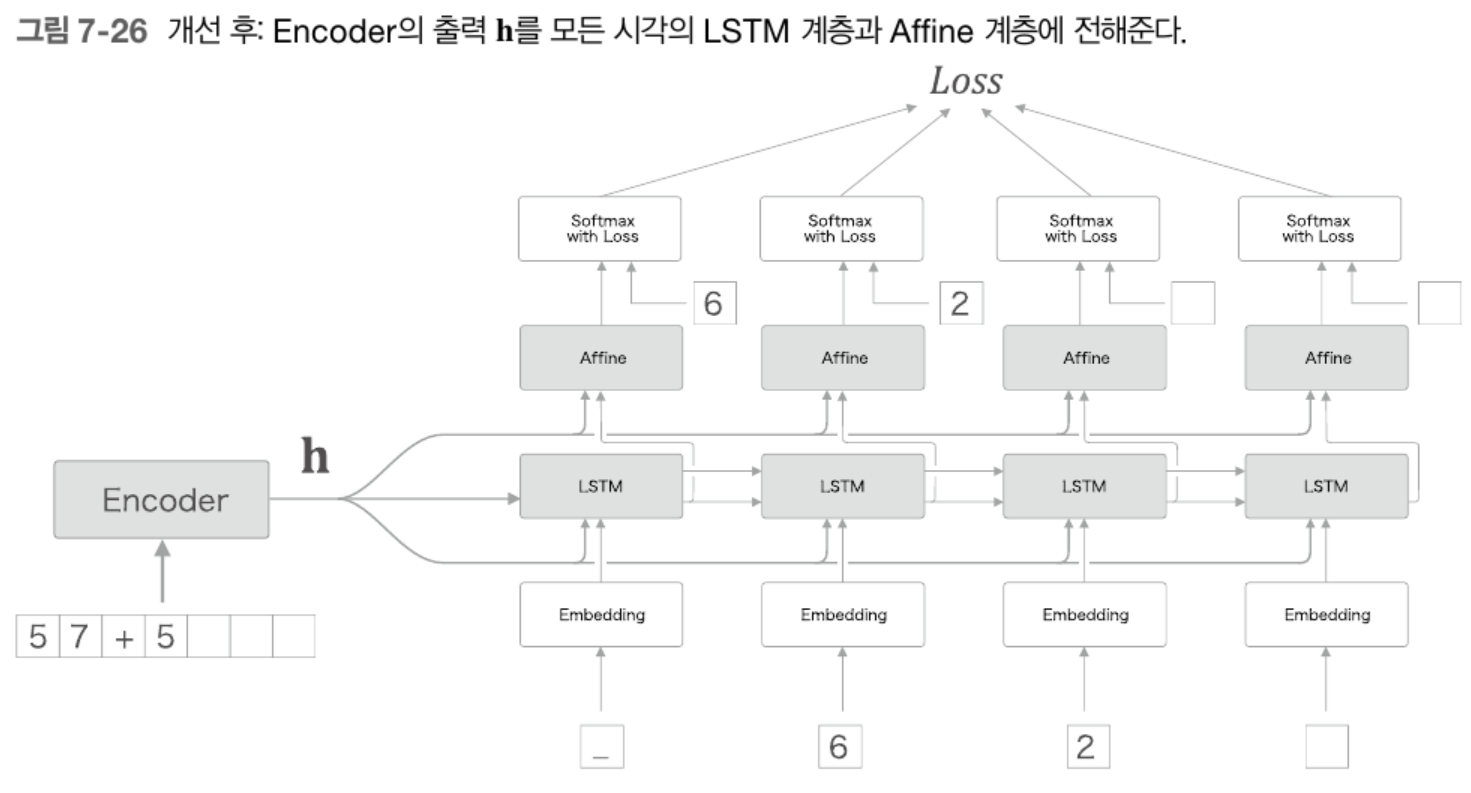

- 입력이 두가지 종류가 되면서 입력을 concat 시켜서 넣어주어야 함

In [ ]:
class PeekyDecoder:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        """
        vocab_size : 총 단어 개수(중복X)
        wordvec_size : embedding size
        hidden_size : hidden size
        """
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # input에 encoder에서 출력되는 h가 추가되기 때문에 사이즈가 커짐
        # 원래 embedding layer에서 출력되는 데이터 크기 : (batch_size, D)
        # 변경 후 embedding layer에서 출력되는 데이터 크기 : (batch_size , D+H)
        embed_W = (rn(V,D)/100).astype("f")
        lstm_Wx = (rn(H+D, 4*H)/np.sqrt(H+D)).astype("f")
        lstm_Wh = (rn(H, 4*H)/np.sqrt(H)).astype("f")
        lstm_b = np.zeros(4*H).astype("f")
        affine_W = (rn(H+H, V)/np.sqrt(H+H)).astype("f")
        affine_b = np.zeros(V).astype("f")
        
        self.embed = TimeEmbedding(embed_W)
        self.lstm = TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful = True)
        self.affine = TimeAffine(affine_W, affine_b)
        
        self.params, self.grads = [], []
        for layer in (self.embed, self.lstm, self.affine):
            self.params += layer.params
            self.grads += layer.grads
        self.cache = None
        
    def forward(self,xs,h):
        N, T = xs.shape
        N, H = h.shape
        
        # encoder에서 출력된 vector h로 set함
        self.lstm.set_state(h)
        
        out = self.embed.forward(xs)
        hs = np.repeat(h, T, axis=0).reshape(N,T,H)
        # LSTM layer의 input을 변경시켜줌
        out = np.concatenate((hs, out), axis=2)
        
        out = self.lstm.forward(out)
        # Affine layer의 input을 변경시켜줌
        out = np.concatenate((hs, out), axis=2)
        
        score = self.affine.forward(out)
        self.cache = H
        return score
    
    def backward(self, dscore):
        H = self.cache
        
        dout = self.affine.backward(dscore)
        # concat 시켜주기 때문에 concat 시킨 input data의 gradient는 앞 계층으로 전달해주지 않음
        dout, dhs0 = dout[:,:,H:], dout[:,:,:H]
        dout = self.lstm.backward(dout)
        dembed, dhs1 = dout[:,:,H:], dout[:,:,:H]
        self.embed.backward(dembed)
        
        # dh 취합
        dhs = dhs0 + dhs1
        dh = self.lstm.dh + np.sum(dhs, axis=1) # 같은 layer의 시각별 gradient를 모두 합친후 첫번째 시각의 ds랑 합쳐줌
        return dh
    
    def generate(self, h, start_id, sample_size):
        sampled = []
        char_id = start_id
        self.lstm.set_state(h)
        
        H = h.shape[1]
        # 한개의 데이터만, 첫번째 시각 데이터만 넣어서 생성해주기 때문에 h의 shape 변환
        peeky_h = h.reshape(1,1,H)
        for _ in range(sample_size):
            x = np.array([char_id]).reshape((1,1))
            out = self.embed.forward(x)
            
            out = np.concatenate((peeky_h,out), axis=2)
            out = self.lstm.forward(out)
            out = np.concatenate((peeky_h,out), axis=2)
            score = self.affine.forward(out)
            
            char_id = np.argmax(score.flatten())
            sampled.append(char_id)
            
        return sampled

In [ ]:
from seq2seq import Seq2seq, Encoder

class PeekySeq2seq(Seq2seq):
    # 구현한 seq2seq 클래스를 계승, 초기화부분만을 변경
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        self.encoder = Encoder(V,D,H)
        self.decoder = PeekyDecoder(V,D,H)
        self.softmax = TimeSoftmaxWithLoss()
        
        self.params = self.encoder.params + self.decoder.params
        self.grads = self.encoder.grads + self.decoder.grads

### Reverse와 Peeky를 모두 적용했을 때의 성능

In [1]:
import sys
import os
sys.path.append(os.path.join("..","function"))
sys.path.append(os.path.join("..","master"))
import numpy as np
import matplotlib.pyplot as plt
from dataset import sequence
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import eval_seq2seq
from seq2seq import Seq2seq
from matplotlib import font_manager, rc
import matplotlib as mpl
from peeky_seq2seq import PeekySeq2seq

font_path = "C:\\Users\\이혜림\\Desktop\\Bita5/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc("font",family=font_name)
mpl.rcParams["axes.unicode_minus"]=False


# 데이터셋 읽기
(x_train, t_train), (x_test, t_test) = sequence.load_data("addition.txt")
x_train, x_test = x_train[:, ::-1], x_test[:, ::-1] # 데이터를 반전시켜줌
char_to_id, id_to_char = sequence.get_vocab()

# 하이퍼파라미터 설정
vocab_size = len(char_to_id)
wordvec_size = 16
hidden_size = 128
batch_size = 128
max_epoch = 25
max_grad = 5.0

# 모델 / optimizer / trainer 생성
model = PeekySeq2seq(vocab_size, wordvec_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

acc_list = []
for epoch in range(max_epoch):
    trainer.fit(x_train, t_train, max_epoch = 1,
               batch_size = batch_size, max_grad = max_grad)
    correct_num = 0
    for i in range(len(x_test)):
        question, correct = x_test[[i]], t_test[[i]] # 각 data를 불러옴
        verbose = i<10  # 앞 10개 시계열 데이터의 결과만 출력
        # question은 출발어 correct는 도착어, verbose는 eval 결과를 출력할지 여부
        correct_num += eval_seq2seq(model, question, correct,
                                   id_to_char, verbose)
    
    # 정답률을 평가 척도로 사용
    acc = float(correct_num) / len(x_test)
    acc_list.append(acc)
    print("검증 정확도 %.3f%%" %(acc*100))

| 에폭 1 |  반복 1 / 351 | 시간 0[s] | 손실 2.57
| 에폭 1 |  반복 21 / 351 | 시간 1[s] | 손실 2.48
| 에폭 1 |  반복 41 / 351 | 시간 2[s] | 손실 2.20
| 에폭 1 |  반복 61 / 351 | 시간 3[s] | 손실 1.99
| 에폭 1 |  반복 81 / 351 | 시간 4[s] | 손실 1.89
| 에폭 1 |  반복 101 / 351 | 시간 5[s] | 손실 1.82
| 에폭 1 |  반복 121 / 351 | 시간 6[s] | 손실 1.82
| 에폭 1 |  반복 141 / 351 | 시간 7[s] | 손실 1.80
| 에폭 1 |  반복 161 / 351 | 시간 8[s] | 손실 1.79
| 에폭 1 |  반복 181 / 351 | 시간 9[s] | 손실 1.78
| 에폭 1 |  반복 201 / 351 | 시간 10[s] | 손실 1.77
| 에폭 1 |  반복 221 / 351 | 시간 11[s] | 손실 1.76
| 에폭 1 |  반복 241 / 351 | 시간 12[s] | 손실 1.76
| 에폭 1 |  반복 261 / 351 | 시간 14[s] | 손실 1.75
| 에폭 1 |  반복 281 / 351 | 시간 15[s] | 손실 1.74
| 에폭 1 |  반복 301 / 351 | 시간 16[s] | 손실 1.74
| 에폭 1 |  반복 321 / 351 | 시간 17[s] | 손실 1.73
| 에폭 1 |  반복 341 / 351 | 시간 18[s] | 손실 1.73
Q   58+77
T 162 
X 100 
---
Q 461+579
T 1139
X 1013
---
Q  48+285
T 666 
X 102 
---
Q   551+8
T 163 
X 100 
---
Q  55+763
T 422 
X 1023
---
Q 752+006
T 857 
X 1023
---
Q 292+167
T 1053
X 1023
---
Q 795+038
T 1427
X 1111
---


| 에폭 8 |  반복 341 / 351 | 시간 16[s] | 손실 0.34
Q   58+77
T 162 
X 161 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
X 657 
---
Q   551+8
T 163 
X 155 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
X 1438
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
검증 정확도 65.040%
| 에폭 9 |  반복 1 / 351 | 시간 0[s] | 손실 0.32
| 에폭 9 |  반복 21 / 351 | 시간 1[s] | 손실 0.31
| 에폭 9 |  반복 41 / 351 | 시간 2[s] | 손실 0.31
| 에폭 9 |  반복 61 / 351 | 시간 3[s] | 손실 0.31
| 에폭 9 |  반복 81 / 351 | 시간 4[s] | 손실 0.29
| 에폭 9 |  반복 101 / 351 | 시간 5[s] | 손실 0.29
| 에폭 9 |  반복 121 / 351 | 시간 6[s] | 손실 0.29
| 에폭 9 |  반복 141 / 351 | 시간 7[s] | 손실 0.27
| 에폭 9 |  반복 161 / 351 | 시간 8[s] | 손실 0.27
| 에폭 9 |  반복 181 / 351 | 시간 9[s] | 손실 0.26
| 에폭 9 |  반복 201 / 351 | 시간 10[s] | 손실 0.25
| 에폭 9 |  반복 221 / 351 | 시간 11[s] | 손실 0.25
| 에폭 9 |  반복 241 / 351 | 시간 12[s] | 손실 0.24
| 에폭 9 |  반복 261 / 351 | 시간 13[s] | 손실 0.24
| 에폭 9 |  반복 281 / 351 | 시간 14[s] | 손실 0.23
| 에폭 9 |  반복 301 

| 에폭 16 |  반복 121 / 351 | 시간 6[s] | 손실 0.04
| 에폭 16 |  반복 141 / 351 | 시간 7[s] | 손실 0.04
| 에폭 16 |  반복 161 / 351 | 시간 8[s] | 손실 0.03
| 에폭 16 |  반복 181 / 351 | 시간 9[s] | 손실 0.04
| 에폭 16 |  반복 201 / 351 | 시간 10[s] | 손실 0.03
| 에폭 16 |  반복 221 / 351 | 시간 11[s] | 손실 0.03
| 에폭 16 |  반복 241 / 351 | 시간 12[s] | 손실 0.03
| 에폭 16 |  반복 261 / 351 | 시간 13[s] | 손실 0.03
| 에폭 16 |  반복 281 / 351 | 시간 14[s] | 손실 0.03
| 에폭 16 |  반복 301 / 351 | 시간 15[s] | 손실 0.03
| 에폭 16 |  반복 321 / 351 | 시간 17[s] | 손실 0.03
| 에폭 16 |  반복 341 / 351 | 시간 18[s] | 손실 0.04
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053
---
Q 795+038
T 1427
O 1427
---
Q  838+62
T 864 
O 864 
---
Q  39+341
T 236 
O 236 
---
검증 정확도 97.180%
| 에폭 17 |  반복 1 / 351 | 시간 0[s] | 손실 0.03
| 에폭 17 |  반복 21 / 351 | 시간 1[s] | 손실 0.03
| 에폭 17 |  반복 41 / 351 | 시간 2[s] | 손실 0.03
| 에폭 17 |  반복 61 / 351 | 시간 3[s] | 손실 0.0

검증 정확도 98.460%
| 에폭 24 |  반복 1 / 351 | 시간 0[s] | 손실 0.01
| 에폭 24 |  반복 21 / 351 | 시간 1[s] | 손실 0.01
| 에폭 24 |  반복 41 / 351 | 시간 2[s] | 손실 0.01
| 에폭 24 |  반복 61 / 351 | 시간 3[s] | 손실 0.01
| 에폭 24 |  반복 81 / 351 | 시간 4[s] | 손실 0.02
| 에폭 24 |  반복 101 / 351 | 시간 5[s] | 손실 0.01
| 에폭 24 |  반복 121 / 351 | 시간 6[s] | 손실 0.02
| 에폭 24 |  반복 141 / 351 | 시간 7[s] | 손실 0.04
| 에폭 24 |  반복 161 / 351 | 시간 8[s] | 손실 0.05
| 에폭 24 |  반복 181 / 351 | 시간 9[s] | 손실 0.06
| 에폭 24 |  반복 201 / 351 | 시간 10[s] | 손실 0.05
| 에폭 24 |  반복 221 / 351 | 시간 11[s] | 손실 0.03
| 에폭 24 |  반복 241 / 351 | 시간 12[s] | 손실 0.03
| 에폭 24 |  반복 261 / 351 | 시간 13[s] | 손실 0.04
| 에폭 24 |  반복 281 / 351 | 시간 15[s] | 손실 0.03
| 에폭 24 |  반복 301 / 351 | 시간 16[s] | 손실 0.03
| 에폭 24 |  반복 321 / 351 | 시간 17[s] | 손실 0.03
| 에폭 24 |  반복 341 / 351 | 시간 17[s] | 손실 0.03
Q   58+77
T 162 
O 162 
---
Q 461+579
T 1139
O 1139
---
Q  48+285
T 666 
O 666 
---
Q   551+8
T 163 
O 163 
---
Q  55+763
T 422 
O 422 
---
Q 752+006
T 857 
O 857 
---
Q 292+167
T 1053
O 1053

### 5. seq2seq를 이용하는 애플리케이션
- seq2seq는 '한 시계열 데이터'를 '다른 시계열 데이터'로 변환
- 2개가 짝을 이루는 시계열 데이터를 다루는 문제에 이용할 수 있음
- seq2seq를 사용하는 다양한 문제
    - 기계 번역 : '한 언어의 문장'을 '다른 언어의 문장'으로 변환
    - 자동 요약 : '긴 문장'을 '짧게 요약된 문장'으로 변환
    - 질의응답 : '질문'을 '응답'으로 변환
    - 메일 자동 응답 : '받은 메일의 문장'을 '답변 글'로 변환
    
- 자연어 외에도 이미지, 음성, 영상 등에도 사용 가능

### 5.1 챗봇
- 사람과 컴퓨터가 텍스트로 대화를 나누는 프로그램
- 학습 데이터 : 대화 데이터
- input : 사용자 말
- output : 응답

### 5.2 알고리즘 학습
- 코드와 그 출력을 시계열 데이터로 볼 수 있음
- 학습 데이터 : 파이썬 코드와 그 출력
- input : 파이썬 코드
- output : 파이썬 코드를 처리한 것

### 5.3 이미지 캡셔닝
- Encoder을 LSTM에서 CNN(VGG/ResNet 등)으로 변경.
- CNN의 최종 출력(높이, 폭, 채널)을 1차원으로 flattening한 후, Affine을 통해 LSTM 계층에 넣을 수 있는 데이터 형태로 변환. 최종 문장 생성
    - 전이학습(transfer learning)을 이용하여 CNN의 가중치를 이미 학습이 완료된 가중치를 사용하면 좋은 결과를 얻을 수 있음